In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from fmri_processing.utils import draw_heat_map
from fmri_processing.functions import funcs
import os

In [8]:
# train_matrix  = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/HC/max.npy'
# test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/test/max.npy'

# train_matrix, test_matrix = test_matrix, train_matrix
def draw_all_subjects(matrix):
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5

    subjects = np.array_split(matrix, sub_num)
    for idx, sub in enumerate(subjects):
        print(f'sub-{idx:02d}')
        draw_heat_map(subjects[idx])

In [7]:
import numpy as np

def z_score_matrix(matrix):
    shape = matrix.shape

    # 1. Разбиваем матрицу на группы по 5 элементов
    flattened = matrix.flatten()  # Преобразуем в 1D-массив
    num_groups = len(flattened) // 5
    groups = flattened[:num_groups * 5].reshape(-1, 5)  # Группы по 5 элементов

    # 2. Вычисляем z-показатели для каждой группы
    z_scores = np.zeros_like(groups)
    for i in range(groups.shape[0]):
        group = groups[i]
        mean = np.mean(group)
        std = np.std(group)
        if std != 0:
            z_scores[i] = (group - mean) / std
        else:
            z_scores[i] = 0  # Если все элементы одинаковые

    # 3. Собираем обратно в матрицу
    flattened_z = z_scores.flatten()
    # Если исходная длина не делилась на 5, добавляем оставшиеся элементы без изменений
    if len(flattened) % 5 != 0:
        remaining = flattened[num_groups * 5:]
        flattened_z = np.concatenate([flattened_z, remaining])

    # Преобразуем обратно в исходную размерность
    result_matrix = flattened_z.reshape(shape)
    return result_matrix

In [8]:
def prepare_data(train_matrix):
    matrix = np.load(train_matrix)
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5    # Количество испытуемых

    labels = np.zeros(N, dtype=int)  # Создаем массив из нулей
    labels[3::5] = 1  # Каждый 4-й элемен
    print(matrix.shape)

    X = matrix
    y = labels


    # Группы для разделения
    groups = np.repeat(np.arange(sub_num), 5)  # [0,0,0,0,0, 1,1,1,1,1,...]

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=30)
    train_idx, test_idx = next(splitter.split(X, y, groups))

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


In [9]:
def train_best_model_by_recall_(train_matrix, target_class=1, test_size=0.3, random_state=42, verbose=True):
    """
    Обучает модели и возвращает лучшую по recall для указанного класса
    
    Параметры:
    X - признаки
    y - целевая переменная
    groups - группы для кросс-валидации
    target_class - класс, для которого оптимизируем recall (по умолчанию 1)
    test_size - доля тестовой выборки
    random_state - для воспроизводимости
    verbose - вывод информации о процессе обучения
    """
    
    matrix = np.load(train_matrix)
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5    # Количество испытуемых

    labels = np.zeros(N, dtype=int)  # Создаем массив из нулей
    labels[3::5] = 1  # Каждый 4-й элемен
    print(matrix.shape)

    X = matrix
    y = labels


    # Группы для разделения
    groups = np.repeat(np.arange(sub_num), 5)  # [0,0,0,0,0, 1,1,1,1,1,...]

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=30)
    train_idx, test_idx = next(splitter.split(X, y, groups))

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    
    # 1. Разделение на train/test с сохранением групп
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(X, y, groups))
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    groups_train = groups[train_idx]
    
    # 2. Инициализация моделей
    models = {
        "Logistic Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(class_weight='balanced', 
                                       max_iter=1000, 
                                       random_state=random_state))
        ]),
        "Random Forest": RandomForestClassifier(class_weight='balanced_subsample', 
                                              random_state=random_state),
        "SVM": Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVC(kernel='rbf', 
                         class_weight='balanced', 
                         probability=True, 
                         random_state=random_state))
        ]),
        "XGBoost": XGBClassifier(
            scale_pos_weight=4,  # Автоматический расчет
            random_state=random_state
        )
    }

    # 3. Кросс-валидация по группам
    gss = GroupShuffleSplit(n_splits=5, test_size=0.3, random_state=random_state)
    model_recalls = []

    for name, model in models.items():
        recall_scores = []
        
        for fold, (train_idx_fold, val_idx_fold) in enumerate(gss.split(X_train, y_train, groups_train)):
            model.fit(X_train[train_idx_fold], y_train[train_idx_fold])
            y_pred = model.predict(X_train[val_idx_fold])
            recall = recall_score(y_train[val_idx_fold], y_pred, pos_label=target_class)
            recall_scores.append(recall)
        
        print(recall_scores)
        mean_recall = np.mean(recall_scores)
        std_recall = np.std(recall_scores)
        model_recalls.append((name, mean_recall, std_recall, model))
        
        if verbose:
            print(f"{name:<20} | Recall (class {target_class}): {mean_recall:.3f} ± {std_recall:.3f}")

        model.fit(X_train, y_train)
    # # 4. Выбор лучшей модели
    # best_name, best_recall, best_std, best_model = max(model_recalls, key=lambda x: x[1])
    
    # # 5. Финальное обучение на полном train наборе
    # best_model.fit(X_train, y_train)
    
    # # 6. Оценка на тестовом наборе
    # test_recall = recall_score(y_test, best_model.predict(X_test), pos_label=target_class)
    
    # if verbose:
    #     print(f"\n{'='*50}")
    #     print(f"BEST MODEL: {best_name}")
    #     print(f"CV Recall (class {target_class}): {best_recall:.3f} ± {best_std:.3f}")
    #     print(f"Test Recall (class {target_class}): {test_recall:.3f}")
    #     print("="*50)

    return models

In [10]:
def train_best_model_by_recall(train_matrix, target_class=1, test_size=0.3, random_state=42, verbose=True):
    """
    Обучает модели и возвращает лучшую по recall для указанного класса
    
    Параметры:
    train_matrix - путь к файлу с матрицей признаков
    target_class - класс, для которого оптимизируем recall
    test_size - доля валидационной выборки в кросс-валидации
    random_state - для воспроизводимости
    verbose - вывод информации о процессе обучения
    
    Возвращает:
    Лучшую модель (по recall на валидации), метрики моделей
    """
    
    # 1. Загрузка данных и подготовка
    matrix = np.load(train_matrix)
    N = matrix.shape[0]
    sub_num = N // 5

    labels = np.zeros(N, dtype=int)
    labels[3::5] = 1
    
    X = matrix
    y = labels
    groups = np.repeat(np.arange(sub_num), 5)

    # 2. Инициализация моделей
    models = {
        "Logistic Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(class_weight='balanced', 
                                       max_iter=1000, 
                                       random_state=random_state))
        ]),



    }
    # from sklearn.model_selection import RandomizedSearchCV
    # from scipy.stats import loguniform  # для логарифмического распределения C

    # param_dist = {
    #     'model__C': loguniform(1e-4, 100),  # C в диапазоне [0.0001, 100]
    #     'model__penalty': ['l1', 'l2', 'elasticnet', None],
    #     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #     'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # для elasticnet
    # }

    # random_search = RandomizedSearchCV(
    #     estimator=models['Logistic Regression'],
    #     param_distributions=param_dist,
    #     n_iter=50,  # количество случайных комбинаций
    #     scoring='accuracy',
    #     cv=5,
    #     n_jobs=-1,
    #     verbose=1,
    #     random_state=random_state
    # )

    # models['Logistic Regression'] = random_search

    # 3. Кросс-валидация по группам
    gss = GroupShuffleSplit(n_splits=5, test_size=test_size, random_state=random_state)
    model_recalls = []

    for name, model in models.items():
        recall_scores = []
        
        for train_idx, val_idx in gss.split(X, y, groups):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[val_idx])
            recall = recall_score(y[val_idx], y_pred, pos_label=target_class)
            recall_scores.append(recall)
        
        mean_recall = np.mean(recall_scores)
        std_recall = np.std(recall_scores)
        model_recalls.append((name, mean_recall, std_recall, model))
        
        if verbose:
            print(f"{name:<20} | Recall (class {target_class}): {mean_recall:.3f} ± {std_recall:.3f}")
        model.fit(X, y)
    # # 4. Выбор лучшей модели
    # best_model_info = max(model_recalls, key=lambda x: x[1])
    # best_model = best_model_info[3]
    
    # # 5. Финальное обучение на всех данных
    # best_model.fit(X, y)
    
    return models

In [11]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    """
    Обучает модели и возвращает лучшую по recall для указанного класса
    
    Параметры:
    train_matrix - путь к файлу с матрицей признаков
    target_class - класс, для которого оптимизируем recall
    random_state - для воспроизводимости
    verbose - вывод информации о процессе обучения
    
    Возвращает:
    Лучшую модель (по recall на валидации), метрики моделей
    """
    
    # 1. Загрузка данных и подготовка
    matrix = np.load(train_matrix)
    N = matrix.shape[0]
    sub_num = N // 5

    labels = np.zeros(N, dtype=int)
    labels[3::5] = 1
    
    X = matrix
    y = labels
    groups = np.repeat(np.arange(sub_num), 5)

    # 2. Инициализация моделей
    models = {
        "Logistic Regression": Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(class_weight='balanced', 
                                       max_iter=1000, 
                                       random_state=random_state))
        ]),
        "Random Forest": RandomForestClassifier(
            class_weight='balanced_subsample', 
            random_state=random_state
        ),
        "SVM": Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVC(kernel='rbf', 
                         class_weight='balanced', 
                         probability=True, 
                         random_state=random_state))
        ]),
        "XGBoost": XGBClassifier(
            scale_pos_weight=(len(y) - sum(y)) / sum(y),
            random_state=random_state,
            eval_metric='logloss'
        )
    }

    # 3. Кросс-валидация с LeaveOneGroupOut
    logo = LeaveOneGroupOut()
    model_recalls = []

    for name, model in models.items():
        recall_scores = []
        
        for train_idx, val_idx in logo.split(X, y, groups=groups):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[val_idx])
            recall = recall_score(y[val_idx], y_pred, pos_label=target_class)
            recall_scores.append(recall)
        
        mean_recall = np.mean(recall_scores)
        std_recall = np.std(recall_scores)
        model_recalls.append((name, mean_recall, std_recall, model))
        
        if verbose:
            print(f"{name:<20} | Recall (class {target_class}): {mean_recall:.3f} ± {std_recall:.3f}")

        model.fit(X,y)
    # # 4. Выбор и финальное обучение лучшей модели
    # best_model_info = max(model_recalls, key=lambda x: x[1])
    # best_model = best_model_info[3].fit(X, y)  # Обучаем на всех данных
    
    return models

In [67]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import recall_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
import optuna

class GroupPreprocessor(BaseEstimator, TransformerMixin):
    """Универсальный препроцессинг для 2D данных"""
    def __init__(self):
        self.scalers = {}
        self.selector = None

    def fit(self, X, y=None, groups=None):
        # Гарантируем 2D формат
        if X.ndim != 2:
            raise ValueError(f"Ожидается 2D массив. Получено {X.ndim}D")
        
        # Групповая стандартизация
        unique_groups = np.unique(groups)
        for group in unique_groups:
            mask = groups == group
            self.scalers[group] = StandardScaler().fit(X[mask])
        
        # Отбор признаков
        self.selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='saga')
        ).fit(X, y)
        
        return self

    def transform(self, X, groups=None):
        if X.ndim != 2:
            raise ValueError(f"Ожидается 2D массив. Получено {X.ndim}D")
        
        # Применение групповой нормализации
        X_scaled = X.copy()
        unique_groups = np.unique(groups)
        for group in unique_groups:
            mask = groups == group
            X_scaled[mask] = self.scalers[group].transform(X[mask])
        
        # Отбор признаков
        return self.selector.transform(X_scaled)

def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    # 1. Загрузка и гарантия 2D формата
    matrix = np.load(train_matrix)
    if matrix.ndim == 3:
        matrix = matrix.reshape(-1, matrix.shape[-1])
    
    # 2. Подготовка меток и групп
    n_samples = matrix.shape[0]
    labels = np.zeros(n_samples, dtype=int)
    labels[3::5] = 1  # 4-й элемент в каждом блоке из 5
    groups = np.repeat(np.arange(n_samples//5), 5)

    # 3. Гарантия совпадения размеров
    if len(groups) != n_samples:
        raise ValueError(
            f"Несоответствие размеров: данные {n_samples}," 
            f" группы {len(groups)}"
        )

    # 4. Определение моделей
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(probability=True)
    }

    # 5. Функция для оптимизации
    def objective(trial):
        model_name = trial.suggest_categorical("model", list(models.keys()))
        
        # Параметры для выбранной модели
        params = {}
        if model_name == "Logistic Regression":
            params.update({
                'C': trial.suggest_float('C', 0.1, 10, log=True),
                'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga'])
            })
        elif model_name == "Random Forest":
            params.update({
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 20)
            })
        elif model_name == "SVM":
            params.update({
                'C': trial.suggest_float('C', 0.1, 10, log=True),
                'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear'])
            })
        
        # Полный пайплайн
        model = models[model_name].set_params(**params)
        pipeline = ImbPipeline([
            ('preproc', GroupPreprocessor()),
            ('smote', SMOTE(random_state=random_state)),
            ('model', model)
        ])
        
        # Кросс-валидация
        scores = []
        for train_idx, val_idx in GroupKFold(n_splits=5).split(matrix, groups=groups):
            pipeline.fit(matrix[train_idx], labels[train_idx])
            y_pred = pipeline.predict(matrix[val_idx])
            scores.append(recall_score(labels[val_idx], y_pred, pos_label=target_class))
        
        return np.mean(scores)

    # 6. Запуск оптимизации
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, timeout=3600)  # Ограничение 1 час
    
    # 7. Лучшая модель
    best_params = study.best_params
    best_model = models[best_params['model']].set_params(**best_params)
    
    final_pipeline = ImbPipeline([
        ('preproc', GroupPreprocessor()),
        ('smote', SMOTE(random_state=random_state)),
        ('model', best_model)
    ]).fit(matrix, labels)

    return {
        'study': study,
        'pipeline': final_pipeline,
        'feature_importances': final_pipeline.named_steps['preproc'].selector.get_support()
    }

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, GridSearchCV
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, recall_score
from sklearn.feature_selection import SelectFromModel

def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    # 1. Загрузка и преобразование данных
    matrix = np.load(train_matrix)
    
    X = matrix
    
    # Создание меток (пример: 1 ложный ответ на 5 вопросов)
    labels = np.zeros(X.shape[0], dtype=int)
    labels[3::5] = 1  # 4-й ответ в каждом блоке из 5 - ложный
    
    # Группы для валидации (по испытуемым)
    groups = np.repeat(np.arange(X.shape[0] // 5), 5)

    # 2. Пайплайн с обработкой
    def create_pipeline(model):
        return ImbPipeline([
            ('scaler', StandardScaler()),  # Простая стандартизация
            ('smote', SMOTE(random_state=random_state)),
            ('feature_selector', SelectFromModel(
                LogisticRegression(penalty='l1', solver='saga', random_state=random_state)
            )),
            ('model', model)
        ])

    # 3. Модели и параметры (обновленный список)
    models = {
        # Существующие модели с расширенными параметрами
        "Logistic Regression": {
            'pipeline': create_pipeline(LogisticRegression(max_iter=1000)),
            'params': {
                'model__C': [0.1, 1, 10, 100],  # Добавлен 100
                'model__class_weight': ['balanced', None],
                'model__solver': ['lbfgs', 'saga', 'liblinear']  # Добавлен liblinear
            }
        },
        "Random Forest": {
            'pipeline': create_pipeline(RandomForestClassifier()),
            'params': {
                'model__n_estimators': [100, 200, 300],  # Добавлен 300
                'model__max_depth': [None, 10, 20],  # Добавлен 20
                'model__class_weight': ['balanced_subsample', None]
            }
        },
        
        # Новые модели
        "SVM": {
            'pipeline': create_pipeline(SVC(probability=True)),  # probability=True для голосования
            'params': {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf'],
                'model__class_weight': ['balanced']
            }
        },
        "XGBoost": {
            'pipeline': create_pipeline(XGBClassifier()),
            'params': {
                'model__n_estimators': [100, 200],
                'model__max_depth': [3, 5, 7],  # Добавлена глубина 7
                'model__learning_rate': [0.01, 0.1, 0.2],  # Добавлен 0.2
                'model__subsample': [0.8, 1.0]  # Новый параметр
            }
        }
    }

    # 4. Обучение с групповой валидацией
    optimized_models = {}
    recall_scorer = make_scorer(recall_score, pos_label=target_class)
    
    for name, config in models.items():
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            cv=GroupKFold(n_splits=5),
            scoring=recall_scorer,
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, labels, groups=groups)
        optimized_models[name] = gs.best_estimator_
        
        if verbose:
            print(f"{name} - Лучшие параметры: {gs.best_params_}")
            print(f"Recall (CV): {gs.best_score_:.3f}\n")

    # 5. Создание и оценка ансамбля
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        voting='soft',
        n_jobs=-1
    )
    
    logo = LeaveOneGroupOut()
    recall_scores = []
    
    for train_idx, val_idx in logo.split(X, labels, groups=groups):
        ensemble.fit(X[train_idx], labels[train_idx])
        y_pred = ensemble.predict(X[val_idx])
        recall_scores.append(recall_score(labels[val_idx], y_pred, pos_label=target_class))
    
    if verbose:
        print(f"Ансамбль - Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    
    return {'models': optimized_models, 'ensemble': ensemble.fit(X, labels)}

/home/aaanpilov/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aaanpilov/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def train_and_predict_on_test(train_matrix, test_matrix):
    models = train_best_model_by_recall(train_matrix)
    model = models['ensemble']
    matrix_test = np.load(test_matrix)
    N_test = matrix_test.shape[0]  # Длина массива
    sub_num_test = N_test // 5

    labels_test = np.zeros(N_test, dtype=int)  # Создаем массив из нулей
    labels_test[3::5] = 1  # Каждый 4-й элемен
    print(model.predict(matrix_test))
    print(classification_report(labels_test, model.predict(matrix_test)))
    # print(models['ensemble'].predict(test_matrix))
    return
    # for name, model in models.items():
    #     print(f'Model: {name}')
    #     matrix_test = np.load(test_matrix)
    #     N_test = matrix_test.shape[0]  # Длина массива
    #     sub_num_test = N_test // 5

    #     labels_test = np.zeros(N_test, dtype=int)  # Создаем массив из нулей
    #     labels_test[3::5] = 1  # Каждый 4-й элемен
    #     print(model.predict(matrix_test))
    #     print(classification_report(labels_test, model.predict(matrix_test)))

In [3]:
proportional_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_HC/auc.npy'
proportional_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_test/auc.npy'

reduced_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/auc_raw_HC.npy'
reduced_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/auc_test.npy'

ranks_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_HC/auc.npy'
ranks_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_test/auc.npy'

# train_matrix  = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/HC/max.npy'
# test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/test/max.npy'

train_matrix = proportional_train_matrix
test_matrix = proportional_test_matrix 

# train_matrix = ranks_train_matrix
# test_matrix = ranks_test_matrix

# train_matrix = reduced_train_matrix
# test_matrix = reduced_test_matrix

train_matrix, test_matrix = test_matrix, train_matrix

In [47]:
def train_different_params(train_matrix_base, test_matrix_base):
    for func_name in funcs.keys():
        if func_name in ('max_min', 'min', 'max'):
            continue
        train_matrix = os.path.join(train_matrix_base, func_name + '.npy')
        test_matrix = os.path.join(test_matrix_base, func_name + '.npy')

        # print('-'*10 + func_name + '-'*10)
        train_and_predict_on_test(train_matrix, test_matrix)
        # print('-' * 100, sep='\n\n\n\n\n\n')

        # train_matrix, test_matrix = test_matrix, train_matrix

        # print('TEST AND TRAIN DATA REVERT' * 10)
        # print('-'*10 + func_name + '-'*10)
        # train_and_predict_on_test(train_matrix, test_matrix)
        # print('-' * 100, sep='\n\n\n\n\n')

# Пропорциональные баллы

In [ ]:
cards = np.load(cards_matrix+'/auc.npy')

draw_all_subjects(cards)

In [49]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_test_data'

schz_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_schz_data'

cards_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_card_hc_data'

train_different_params(train_matrix_base, test_matrix_base)

# train_different_params(test_matrix_base, cards_matrix)


/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - Лучшие параметры: {'model__C': 1, 'model__class_weight': 'balanced', 'model__solver': 'saga'}
Recall (CV): 0.800



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Random Forest - Лучшие параметры: {'model__class_weight': 'balanced_subsample', 'model__max_depth': None, 'model__n_estimators': 100}
Recall (CV): 0.583



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Ансамбль - Recall: 0.706 ± 0.456
[0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 0]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        40
           1       0.58      0.70      0.64        10

    accuracy                           0.84        50
   macro avg       0.75      0.79      0.77        50
weighted avg       0.85      0.84      0.85        50



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Баллы по 1,2 

In [ ]:
cards = np.load(reduced_cards_matrix_base+'/auc.npy')

draw_all_subjects(cards)

In [50]:
reduced_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_hc_data'
reduced_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_test_data'


reduced_schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_schz_data'

reduced_cards_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_card_hc_data'


train_different_params(reduced_train_matrix_base, reduced_test_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_schz_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_cards_matrix_base)

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - Лучшие параметры: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}
Recall (CV): 0.517



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Random Forest - Лучшие параметры: {'model__class_weight': 'balanced_subsample', 'model__max_depth': 10, 'model__n_estimators': 200}
Recall (CV): 0.500



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Ансамбль - Recall: 0.588 ± 0.492


/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 1 0]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.67      0.40      0.50        10

    accuracy                           0.84        50
   macro avg       0.77      0.68      0.70        50
weighted avg       0.82      0.84      0.82        50



# Просто баллы

sub-00


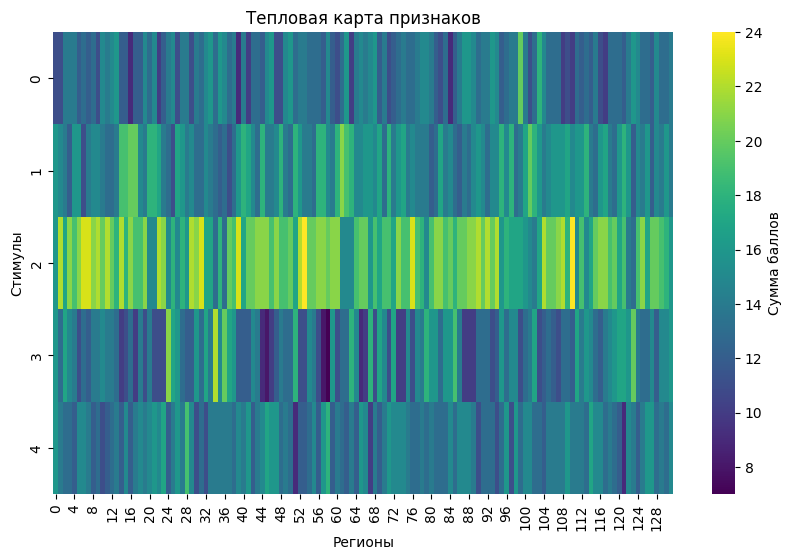

sub-01


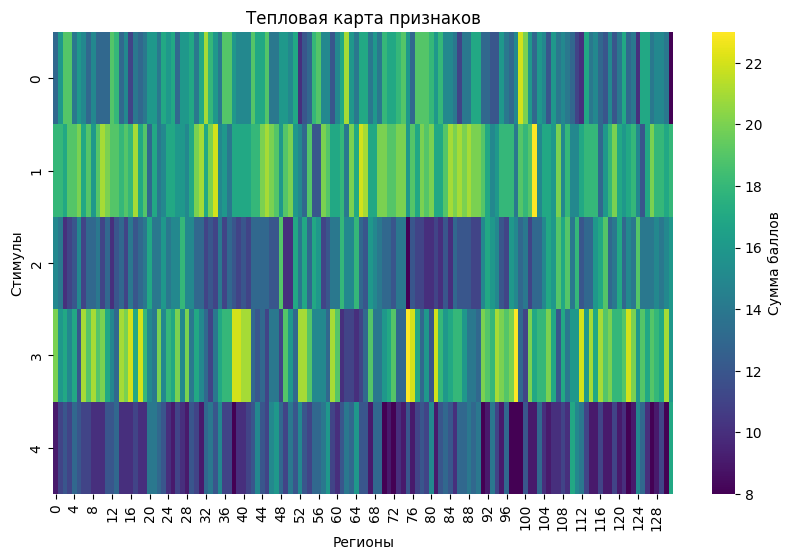

sub-02


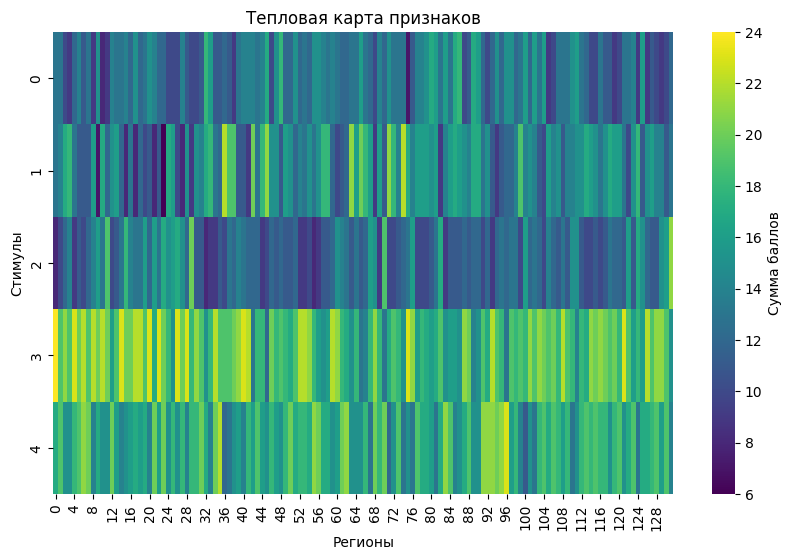

sub-03


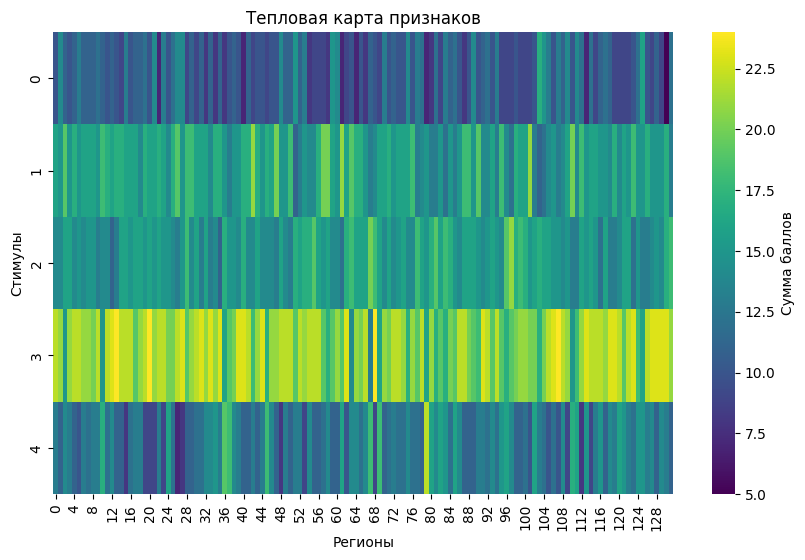

sub-04


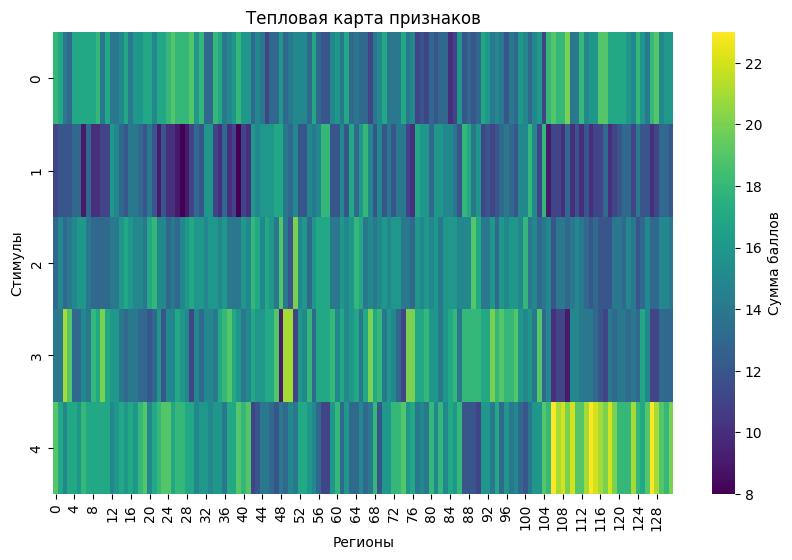

sub-05


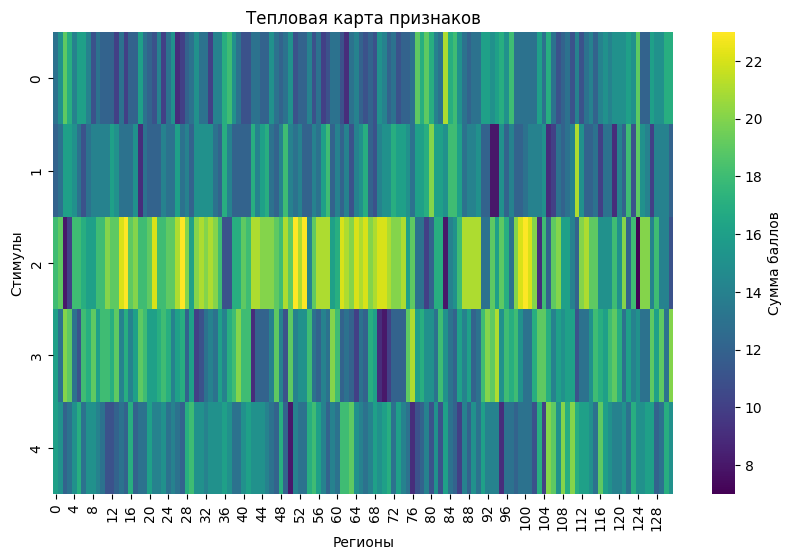

sub-06


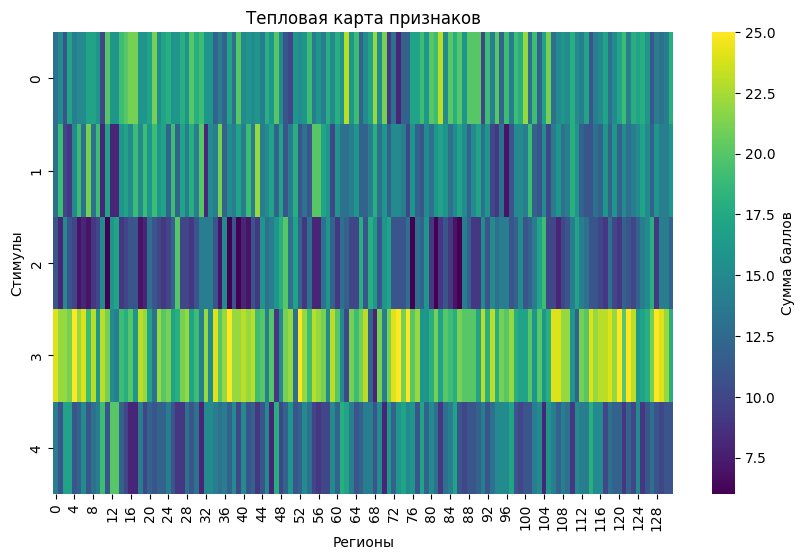

sub-07


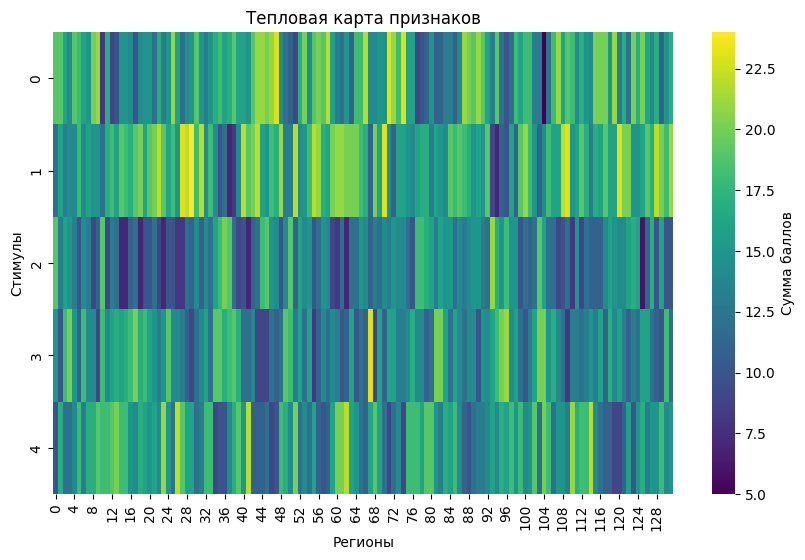

sub-08


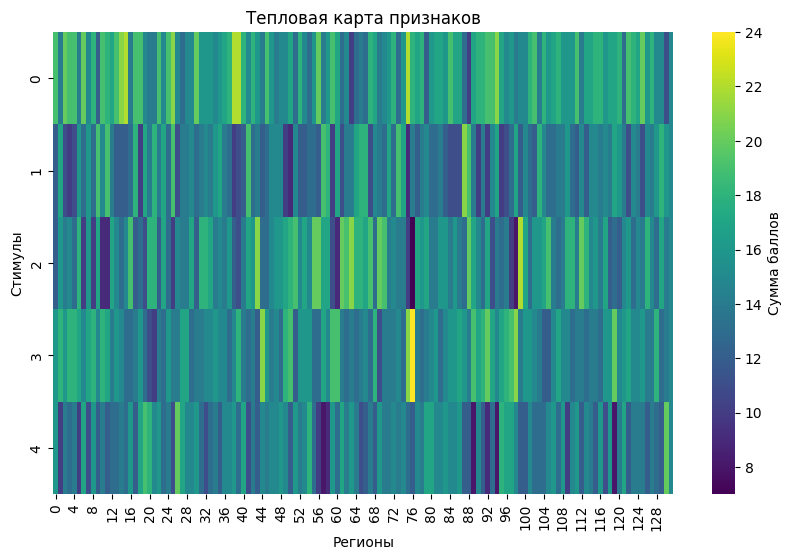

sub-09


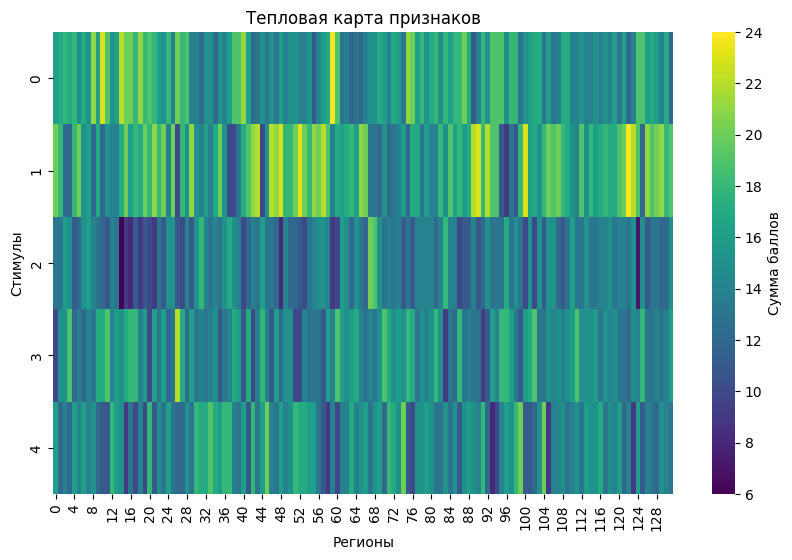

sub-10


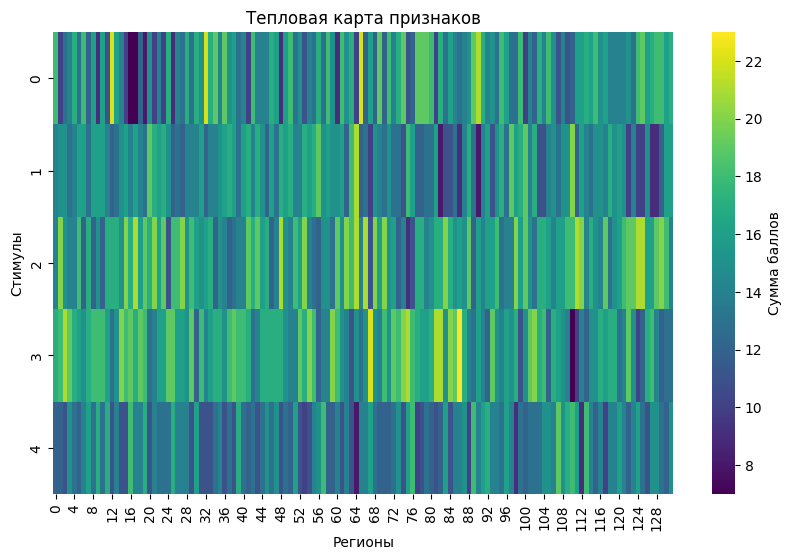

sub-11


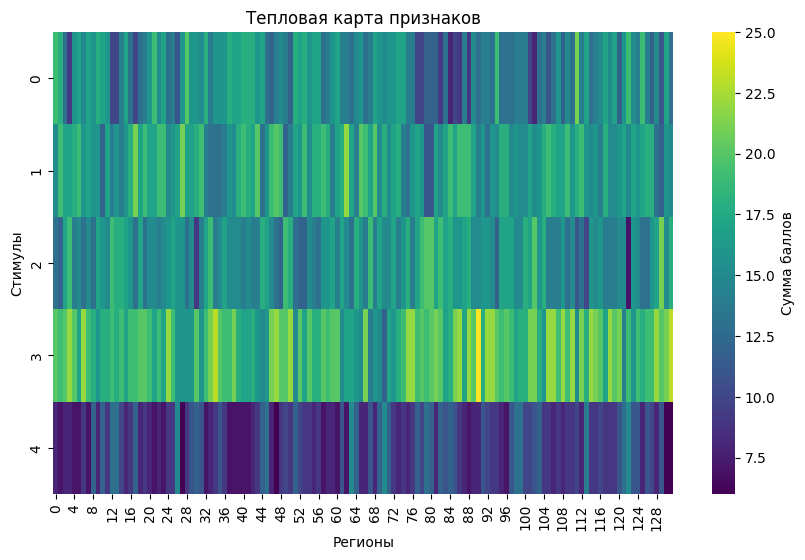

sub-12


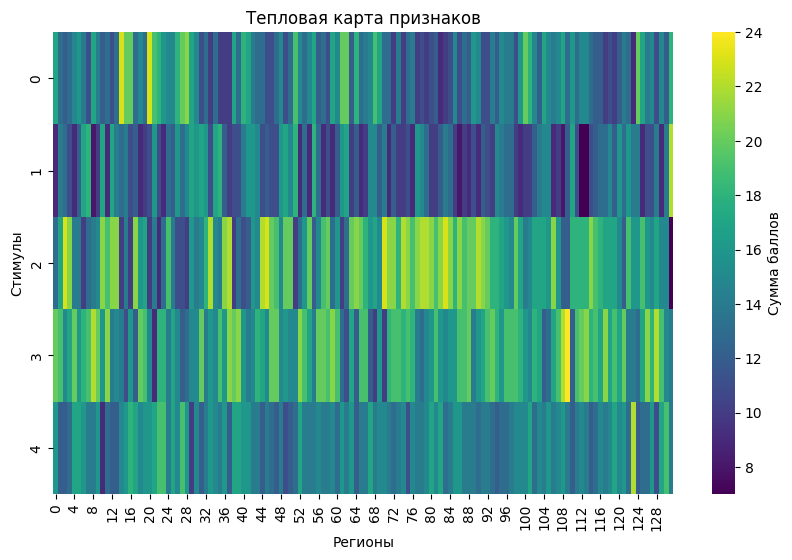

sub-13


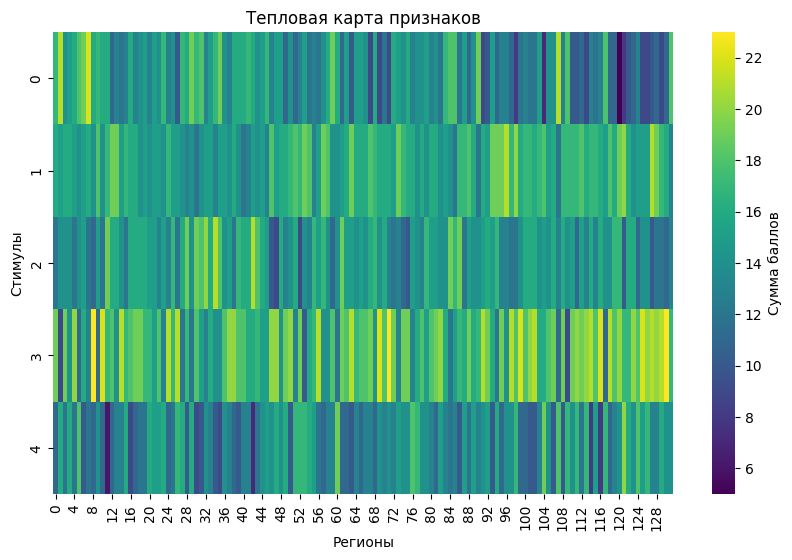

sub-14


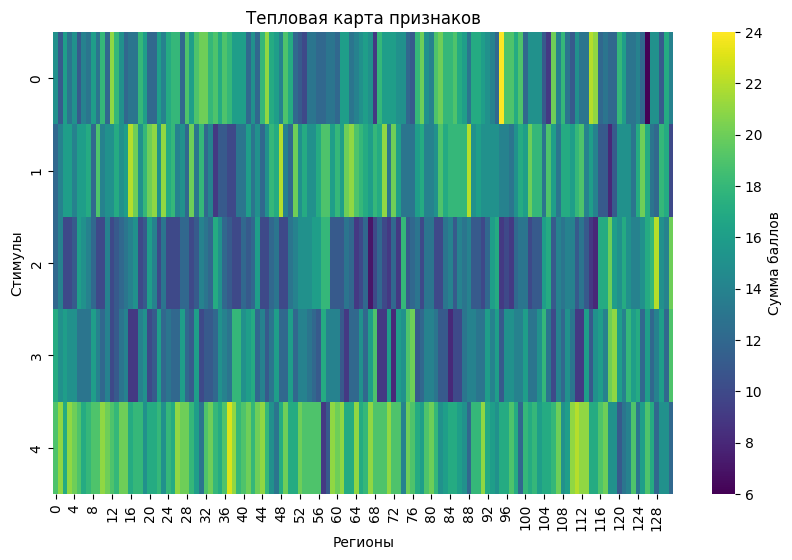

sub-15


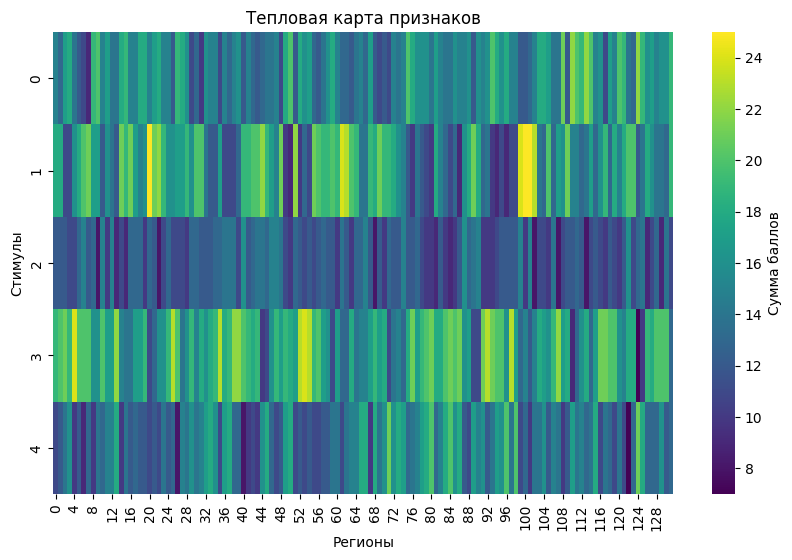

sub-16


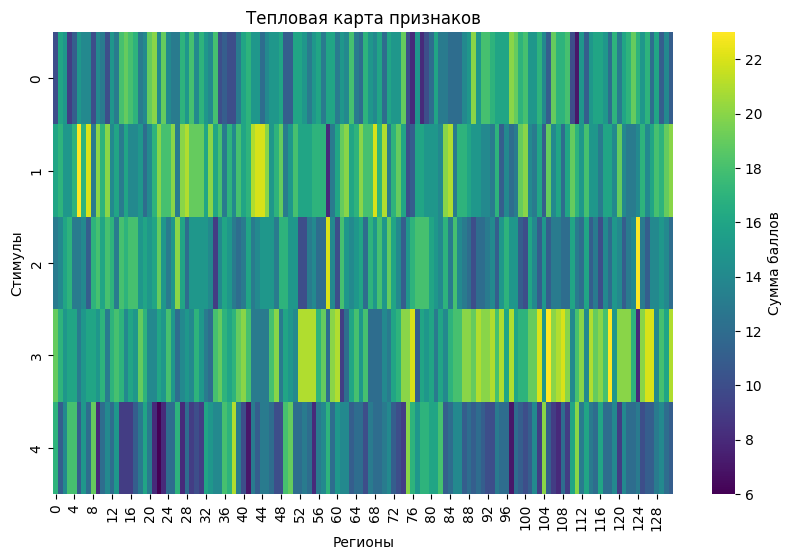

In [13]:
from yaml import safe_load
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def draw_all_subjects(matrix):
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5

    subjects = np.array_split(matrix, sub_num)
    def draw_heat_map(data):
        '''
            Создает тепловую карту для данных размера (x, 132)
        '''
        plt.figure(figsize=(10, 6))  # Задаем размер графика
        sns.heatmap(data, cmap='viridis', cbar_kws={'label': 'Сумма баллов'})  # 'viridis' — цветовая карта
        plt.title('Тепловая карта признаков')
        plt.xlabel('Регионы')
        plt.ylabel('Стимулы')
        plt.show()
    for idx, sub in enumerate(subjects):
        print(f'sub-{idx:02d}')
        draw_heat_map(subjects[idx])

cards = np.load(ranks_train_matrix+'/auc.npy')

draw_all_subjects(cards)

In [1]:
ranks_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_hc_data'
ranks_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_test_data'

ranks_schz_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_schz_data'

ranks_card_hc_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_card_hc_data'

# train_different_params(ranks_test_matrix, ranks_train_matrix)
# print('SCHZ'*30)
# train_different_params(ranks_test_matrix, ranks_schz_matrix)

train_different_params(ranks_train_matrix, ranks_card_hc_matrix)

NameError: name 'train_different_params' is not defined

In [ ]:
cards = np.load(test_matrix_base+'/auc.npy')

draw_all_subjects(cards)

In [53]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/test_data'

schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/schz_data'
card_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_hc_data'
card_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_test_data'

# train_different_params(train_matrix_base, card_train_matrix_base)
# print('SCHZ'*20)
train_different_params(train_matrix_base, test_matrix_base)

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - Лучшие параметры: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}
Recall (CV): 0.600



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Random Forest - Лучшие параметры: {'model__class_weight': None, 'model__max_depth': None, 'model__n_estimators': 100}
Recall (CV): 0.667



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Ансамбль - Recall: 0.647 ± 0.478
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.88      0.70      0.78        10

    accuracy                           0.92        50
   macro avg       0.90      0.84      0.86        50
weighted avg       0.92      0.92      0.92        50



/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/prizes/HC'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/prizes/test'


train_different_params(train_matrix_base, test_matrix_base)

In [18]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_test_data'
for func_name in funcs.keys():
    if func_name in ('max_min', 'min'):
        continue
    train_matrix = os.path.join(train_matrix_base, func_name + '.npy')
    test_matrix = os.path.join(test_matrix_base, func_name + '.npy')

    print('-'*10 + func_name + '-'*10)
    train_and_predict_on_test(train_matrix, test_matrix)
    print('-' * 100, sep='\n\n\n\n\n\n')

----------auc----------
Logistic Regression  | Recall (class 1): 0.294 ± 0.456
Random Forest        | Recall (class 1): 0.000 ± 0.000
SVM                  | Recall (class 1): 0.206 ± 0.404
XGBoost              | Recall (class 1): 0.059 ± 0.235
Model: Logistic Regression
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.33      0.30      0.32        10

    accuracy                           0.74        50
   macro avg       0.58      0.57      0.58        50
weighted avg       0.73      0.74      0.73        50

Model: Random Forest
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        40
           1       0.00      0.00      0.00        10

    accurac

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression  | Recall (class 1): 0.235 ± 0.424
Random Forest        | Recall (class 1): 0.000 ± 0.000
SVM                  | Recall (class 1): 0.029 ± 0.169
XGBoost              | Recall (class 1): 0.000 ± 0.000
Model: Logistic Regression
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        40
           1       0.27      0.30      0.29        10

    accuracy                           0.70        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.71      0.70      0.71        50

Model: Random Forest
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        40
           1       0.00      0.00      0.00        10

    accuracy                       

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
